# UCLQ Quantum Energy Hackathon 
## Working example - February 2022

## Updated notebook with the updates of Giancarlo and Mauro

The old code is named "Old code". 

### [QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html) (Quantum Approximate Optimization Algorithm) is a hearistic method of using quantum computing hardware as it is to find solutions to optimization problems.

### 1. Install quiskit 

In [14]:
# uncomment if qiskit is not installed
# !pip install qiskit

# Associated depenency 
#!pip install pylatexenc

In [25]:
%matplotlib inline
#matplotlib.style.use('seaborn')
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

### 2. Define the parameters of your problem
In this example, we considered the cost and revenue for 3 renewable energy sources and optimised their distribution for 4 locations in the United Kingdom. Data used for this example is contained in _EQ_constants.csv_

For each energy source in each location the following parameters were estimated: 

    1) Revenue: total energy generated by the renewable energy unit
    
    2) Cost: total cost of constructing and mantaining the renewable energy unit
    
    3) Location capacity: the maximum number of units that can be placed in each location, note that a solar unit in this example is a solar pannel and a wind unit is a wind turbine.
    
The total cost is the total energy consumption for the United Kingdom in 2019. NOTE: the units for all the parameters are transformed in sterling pounds £. For full details consult the provided spreadsheet _EQ_constants.csv_


## Old code

In [16]:
# Renewable sources: solar, on-shore and off-shore wind turbines
number_of_renewable_sources = 3
# Locations: England, Northern Ireland, Scotland, Wales
number_of_locations = 4

# Calculate the number of qubits needed, 
# NOTE: IBMQ systems accesible have 5 qubits
nqubits = number_of_locations * number_of_renewable_sources

G = nx.complete_graph(nqubits)

total_cost = C = 61510030000.0 # units: £

# Calculate revenue for each energy source in all locations 
# dict{location: [energy_source]}
location_revenue_per_unit = {
    0: [2783.55, 336113.74, 153105454.50],
    1: [2332.31, 434451.22, 0.0],
    2: [1088.38, 1020438.50, 85798571.43],
    3: [3573.59, 768855.93, 140790000],
}

# Calculate cost for each energy source in all locations
# dict{location: [energy_source]}
location_cost_per_unit = {
    0: [300.92, 52370.72, 22696783.84],
    1: [273.66, 70226.14, 0.0],
    2: [116.17, 161395.70, 11626961.90],
    3: [382.92, 122708.47, 21872844.44],
}

# variable and a rough estimate, see spreadsheet for current figures.
# dict{location: [energy_source]}
location_unit_capacity = {
    0: [800000, 5000, 40],
    1: [30000, 1400, 0],
    2: [70000, 4000, 10],
    3: [60000, 1000, 5],
}

# lambda and gamma, the initial parameter guess for the cost function
lam, gam = 1.0, 1.0

# Calculate the total costs and revenues 
a_revs, b_costs = [], []

for N in range(number_of_locations):
    for R in range(number_of_renewable_sources):
        num_units = location_unit_capacity[N][R]
        a_revs.append(num_units * location_revenue_per_unit[N][R])
        b_costs.append(num_units * location_cost_per_unit[N][R])

## One additional energy source input (New code)
In the following cell, we are adding one more energy source: sewage gas. 

In [51]:
# Renewable sources: solar, on-shore, off-shore wind turbines and sewage gas
number_of_renewable_sources = 4
# Locations: England, Northern Ireland, Scotland, Wales
number_of_locations = 4

# Calculate the number of qubits needed, 
# NOTE: IBMQ systems accesible have 5 qubits
nqubits = number_of_locations * number_of_renewable_sources

G = nx.complete_graph(nqubits)

total_cost = C = 61510030000.0 # units: £

# Calculate revenue for each energy source in all locations 
# dict{location: [energy_source]}
location_revenue_per_unit = {
    0: [2087.6625000000004, 252085.305, 114829090.875, 823616.0700000001],
    1: [1749.2325, 325838.415, 0.0, 0.0],
    2: [816.2850000000001, 765328.875, 64348928.572500005, 516562.5],
    3: [2680.1925, 576641.9475, 105592500.0, 436406.25],
}

# Calculate cost for each energy source in all locations
# dict{location: [energy_source]}
location_cost_per_unit = {
    0: [225.69, 39278.04, 17022587.88, 5944.5599999999995],
    1: [205.245, 52669.604999999996, 0.0, 0.0],
    2: [87.1275, 121046.77500000001, 8720221.425, 3849.5625],
    3: [287.19, 92031.35250000001, 16404633.330000002, 3574.5975],
}



# variable and a rough estimate, see spreadsheet for current figures.
# dict{location: [energy_source]}
location_unit_capacity = {
    0: [800000, 5000, 40, 200],
    1: [30000, 1400, 0, 2],
    2: [70000, 4000, 10, 10],
    3: [60000, 1000, 5, 20],
}

# lambda and gamma, the initial parameter guess for the cost function
lam, gam = 1.0, 1.0

# Calculate the total costs and revenues 
a_revs, b_costs = [], []

for N in range(number_of_locations):
    for R in range(number_of_renewable_sources):
        num_units = location_unit_capacity[N][R]
        a_revs.append(num_units * location_revenue_per_unit[N][R])
        b_costs.append(num_units * location_cost_per_unit[N][R])

In [49]:
a1 = [382.92, 122708.47, 21872844.44, 4766.13]


In [50]:
[a * 0.75 for a in a1]

[287.19, 92031.35250000001, 16404633.330000002, 3574.5975]

### 3. Define the cost function

The optimisation problem to solved can be described by:
$$ \min_{x_i \in \{0,1\}} f( X = x_1, \dotsc,x_n) =   \gamma \ f_{\text{cost}} (X) -\lambda   f_{\text{yield}}(X)$$


In cost function specific for our example is defined as:

$$ \min_{X \in \{0,1\}^{N\times R}} f(X = x_{11}, \dotsc,x_{nr}) = \lambda\left(C-   \sum_i^{N}\sum_j^{R} a_{ij} x_{ij}\right)^2 + \gamma  \sum_i^{N}\sum_j^{R} b_{ij} x_{ij}\ ,$$

for more details please consult the pdf document provided.


In [52]:
def cost_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
    Returns:
        obj: float
             Objective
    """
    obj = lam * C**2
    for i in G.nodes():
        obj += (lam * a_revs[i]**2 + gam * b_costs[i] - 2*lam*C*a_revs[i]) * int(x[i])

    for i, j in G.edges():
        obj += 2 * lam * a_revs[i] * a_revs[j] * int(x[i]) * int(x[j])
            
    return obj

### 4. Define the expectation function

In [53]:
def compute_expectation(counts, G):
    """
    Computes expectation value based on measurement results
    Args:
        counts: dict
                key as bitstring, val as count
        G: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = cost_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


### 5. Define the circuit for QAOA algorithm (Old Code)

The function will bring the different circuit components that build the qaoa circuit under a single function

In [54]:
#old function

def create_qaoa_circ(G, theta):
    """
    Creates a parametrized qaoa circuit
    Args:  
        G: networkx graph
        theta: list
               unitary parameters  
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        # problem unitary biases
        for i in list(G.nodes()):
            qc.rz(2 * gamma[irep], i)
        # problem unitary couplings
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

## Change mixer in the QAOA

One can add the Pauli gate $\sigma_y$ in the mixer Hamiltonian in order to improve the search of the minimum value in the energy. 

In [55]:
### new function
def newcreate_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    betax = theta[:p]
    betay = theta[:p] ### new to the code
    #betaz = theta[:p]
    
    
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary biases
        for i in list(G.nodes()):
            qc.rz(2 * gamma[irep], i)
        # problem unitary couplings
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * betax[irep], i)
            qc.ry(2 * betay[irep], i) ### new to the code
            #qc.rz(2 * betaz[irep], i)
        
            
    qc.measure_all()
        
    return qc

### 6. Define function to run the quantum circuit on the backend of choosing (in this example the IBM Air simulator was used)

In [56]:
def get_expectation(G, p, shots=1012):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        #qc = create_qaoa_circ(G, theta) ### old code
        qc = newcreate_qaoa_circ(G, theta) ### new code
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=1012).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

### 7. Optimize the quantum circuit parameters (New code)

Changing the initial parameters helps to improve the probabilities. 

In [57]:
### The initial values were [1.0,1.0], now we have changed to [0.1,0.2]. This improves the probabily 
## of the result 1111111111111111 meanwhile decreses the other results


expectation = get_expectation(G, p=1)

#res = minimize(expectation, [0.1, 0.2], method='Nelder-Mead') ## try a new method
res = minimize(expectation, [0.1, 0.2], method='COBYLA')
res

     fun: 2.3317872044415013e+21
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 45
  status: 1
 success: True
       x: array([ 0.75531139, -0.0048384 ])

### 8. Run quantum circuit

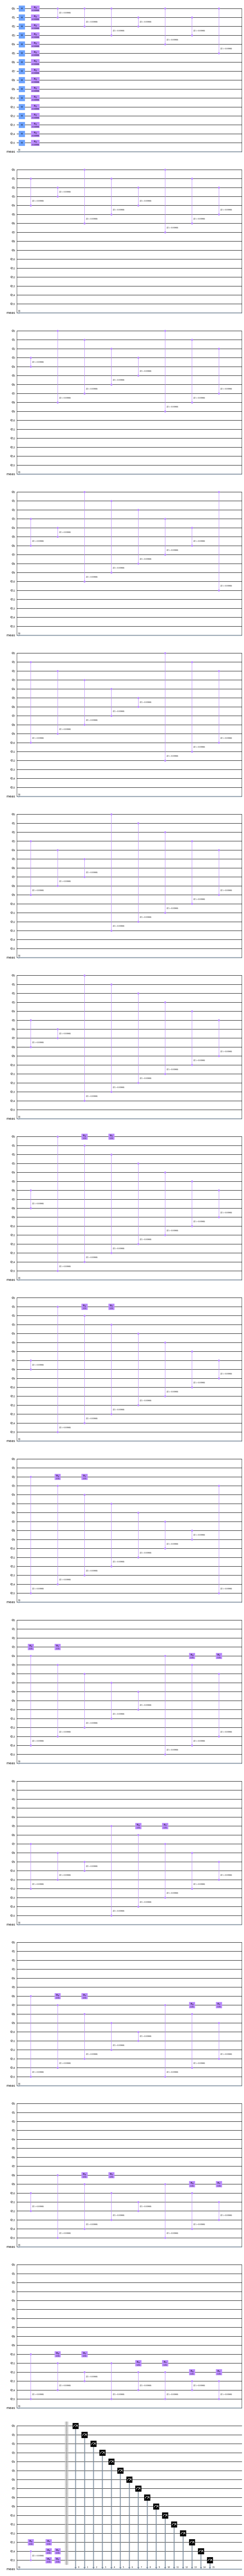

In [58]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 1012

#qc_res = create_qaoa_circ(G, res.x) ### old code
qc_res = newcreate_qaoa_circ(G, res.x)
# Visualise the quantum circuit
qc_res.draw(output='mpl')

### 8. Analyse the resulting distribution

<ipython-input-59-5bb77e3a9467>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xs, fontsize=10, rotation=-45)


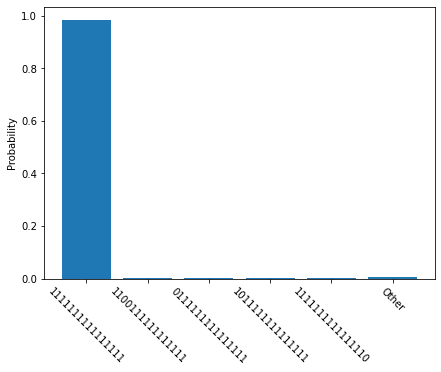

In [59]:
# Obtain simulation results
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
strings = list(counts.keys())
probabilities = np.array([counts[string]/1024 for string in strings])

# Plot the first 5 highest scores (energy sources and corresponding locations)
num_highest = 5
perm = np.flip((np.argsort(probabilities)))
indices = perm[0:num_highest]
xs = [strings[i] for i in indices] + ["Other"]
ys = [probabilities[i] for i in indices] + [sum(probabilities[perm[num_highest:]])]


fig, ax = plt.subplots(1, 1,figsize=(7, 5))
ax.bar(xs, ys)
ax.set_xticklabels(xs, fontsize=10, rotation=-45)
ax.set_ylabel("Probability")
plt.show()